# Інспекційний ноутбук

1. Дані (найбільш вірогідна причина)
Інспекція якості даних:

- Розподіл цільової змінної: чи є викиди, асиметрія, мультимодальність
- Лінійність зв'язків: scatter plots між предикторами і таргетом
- Мультиколінеарність: VIF > 10, correlation matrix
- Пропущені значення: паттерни пропусків (MAR, MCAR, MNAR)
- Noise-to-signal ratio: чи не домінує шум над корисним сигналом

1. 1. Особливості датасету:

- Розмір вибірки: малий датасет vs кількість фічей (curse of dimensionality)
- Нерелевантні фічі: можливо, багато фічей не несуть предиктивної інформації

2. Preprocessing (часта причина проблем)
Encoder'и:

- Target Encoding: overfitting на train, особливо з малими категоріями
- Frequency Encoding: втрата семантичної інформації
- Ordinal Encoding: неправильний порядок категорій

Масштабування:

- Data leakage: чи фітується scaler на всьому датасеті до train/test split
- Outliers: StandardScaler чутливий до викидів (краще RobustScaler)

3. Модель і гіперпараметри
Навіть з GridSearch можливі проблеми:

- Неадекватний search space: занадто вузький діапазон параметрів
- Cross-validation strategy: чи відповідає структурі даних
- Baseline comparison: чи порівнювалися різні типи моделей (linear vs tree-based vs neural)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# acces to project_root -> data
import sys
from pathlib import Path
sys.path.append('..')


In [2]:
from paths import DATA_DIR
df = pd.read_csv(DATA_DIR / 'prepared_data.csv')
df


,salary_usd,title,category,position_grouped,english_level,it_experience_years
0,2000.0,Middle,Marketing,Marketing Manager,Upper-Intermediate,4.00
1,3000.0,Senior,Software Engineer,"Software Engineer / Developer (frontend, backe...",Pre-Intermediate,8.00
2,282.0,Junior,Software Engineer,"Software Engineer / Developer (frontend, backe...",Pre-Intermediate,0.25
3,2700.0,Middle,Quality Assurance,Manual QA,Upper-Intermediate,4.00
4,2500.0,Middle,Software Engineer,"Software Engineer / Developer (frontend, backe...",Intermediate,4.00
...,...,...,...,...,...,...
11680,3000.0,Middle,Software Engineer,"Software Engineer / Developer (frontend, backe...",Intermediate,4.00
11681,2500.0,Middle,Analyst,System Analyst,Upper-Intermediate,1.50
11682,4500.0,Senior,Software Engineer,"Software Engineer / Developer (frontend, backe...",Upper-Intermediate,9.00
11683,1000.0,Middle,Software Engineer,"Software Engineer / Developer (frontend, backe...",Upper-Intermediate,3.00


## Analysis of the target value (y)

In [14]:
df['salary_usd'].describe()


count    11685.000000
mean      3231.505930
std       2319.571734
min          0.000000
25%       1500.000000
50%       2700.000000
75%       4430.000000
max      30000.000000
Name: salary_usd, dtype: float64

In [26]:
# відображення квантилів, щоб побачити розподіл зарплати по певних відсотках
df['salary_usd'].quantile([0.01, 0.05, 0.1, 0.9, 0.95, 0.99])


0.01      385.0
0.05      650.0
0.10      900.0
0.90     6000.0
0.95     7300.0
0.99    11000.0
Name: salary_usd, dtype: float64

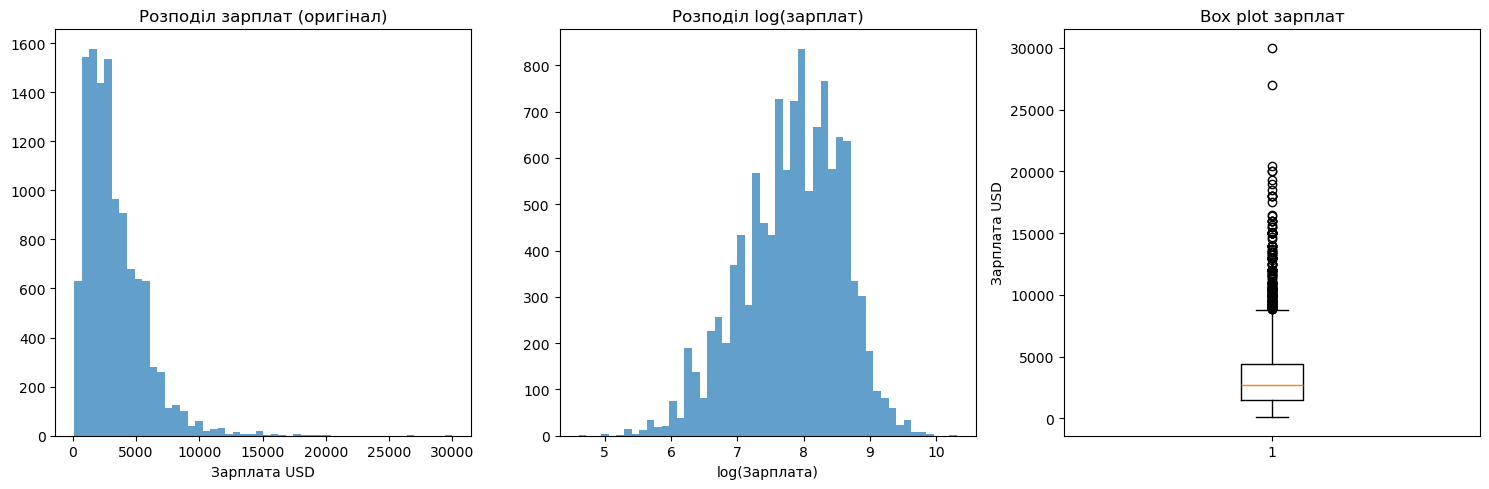


Потенційні викиди:
Зарплати < $800: 860 записів
Зарплати > $8000: 379 записів


In [32]:
# Візуалізація розподілу
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Оригінальний розподіл
axes[0].hist(df['salary_usd'], bins=50, alpha=0.7)
axes[0].set_title('Розподіл зарплат (оригінал)')
axes[0].set_xlabel('Зарплата USD')

# Log-трансформований розподіл (тільки для позитивних зарплат)
log_salaries = np.log(df['salary_usd'])
axes[1].hist(log_salaries, bins=50, alpha=0.7)
axes[1].set_title('Розподіл log(зарплат)')
axes[1].set_xlabel('log(Зарплата)')

# Box plot для викидів
axes[2].boxplot(df['salary_usd'])
axes[2].set_title('Box plot зарплат')
axes[2].set_ylabel('Зарплата USD')

plt.tight_layout()
plt.show()

# Підрахунок потенційних викидів
low_outliers = (df['salary_usd'] < 800).sum()
high_outliers = (df['salary_usd'] > 8000).sum()
print(f"\nПотенційні викиди:")
print(f"Зарплати < $800: {low_outliers} записів")
print(f"Зарплати > $8000: {high_outliers} записів")


In [10]:
df.describe()


,salary_usd,it_experience_years
count,11685.000000,11685.000000
mean,3231.505930,5.472058
std,2319.571734,4.056731
min,0.000000,0.100000
25%,1500.000000,3.000000
50%,2700.000000,5.000000
75%,4430.000000,7.000000
max,30000.000000,20.000000


In [30]:
indices_drop = df[df['salary_usd'] <= 0].index
df.drop(indices_drop, inplace=True)
df[df['salary_usd'] <= 0]


,salary_usd,title,category,position_grouped,english_level,it_experience_years


In [43]:
def test_view():
    x = df[df['salary_usd'] > 10000]
    x['title'].value_counts()
    display(x)
test_view()


,salary_usd,title,category,position_grouped,english_level,it_experience_years
38,12000.0,Head,Security,Other,Advanced,18.0
57,16000.0,Architect,Software Engineer,"Software Engineer / Developer (frontend, backe...",Advanced,14.0
74,11500.0,Middle,Software Engineer,"Software Engineer / Developer (frontend, backe...",Advanced,6.0
226,13450.0,Architect,Software Engineer,Other,Advanced,13.0
230,12000.0,Head,DevOps,Other,Advanced,12.0
...,...,...,...,...,...,...
11454,12500.0,Lead / Team Lead,Software Engineer,"Software Engineer / Developer (frontend, backe...",Intermediate,7.0
11459,14000.0,Senior,Software Engineer,"Software Engineer / Developer (frontend, backe...",Advanced,8.0
11465,12000.0,Tech Lead,Software Engineer,"Software Engineer / Developer (frontend, backe...",Advanced,11.0
11531,13000.0,CEO / C-level (Chief) / Director / VP,Tech Leadership,CTO (Chief Technology Officer) / Technical Dir...,Advanced,5.0


In [55]:
salary_by_Cat = df.groupby('category')['salary_usd'].agg(['mean', 'median', 'count'])
salary_by_Cat.sort_values(by=['count'], ascending=False)


,mean,median,count
category,,,
Software Engineer,3746.535631,3400.00,5106
Quality Assurance,2510.337101,2200.00,1973
Analyst,2474.163503,2100.00,551
DevOps,4656.507921,4150.00,505
Project Management,2870.492537,2500.00,469
Data Scientist,3778.636364,3439.00,330
Product Management,3666.051282,3500.00,312
"UI/UX, Product Design",2693.384615,2350.00,299
HR,2316.676157,2000.00,281


In [ ]:
df = df.drop(columns=['position_grouped'])


In [58]:
df['category'].value_counts()


category
Software Engineer                     5106
Quality Assurance                     1973
Analyst                                551
DevOps                                 505
Project Management                     469
Data Scientist                         330
Product Management                     312
UI/UX, Product Design                  299
HR                                     281
Marketing                              229
Rcrt                                   210
Brand                                  169
Sales                                  133
SysAdmin                               130
Artist/Animator                        111
Other Management                       105
Tech Leadership                         91
Customer Support                        65
Design                                  64
Technical Support                       61
Security                                57
Game design                             56
LD                                      45
Su

In [61]:
df.columns


Index(['salary_usd', 'title', 'category', 'english_level',
       'it_experience_years'],
      dtype='object')

In [62]:
# Розділяємо дані
se_df = df[df['category'] == 'Software Engineer']
other_df = df[df['category'] != 'Software Engineer']

# Стратифікований sampling - зберігаємо пропорції по групах
se_sampled = se_df.groupby(['it_experience_years', 'english_level'], group_keys=False).apply(
    lambda x: x.sample(min(len(x), max(1, int(1500 * len(x) / len(se_df)))),
                      random_state=42)
)

# Об'єднуємо
balanced_df = pd.concat([se_sampled, other_df], ignore_index=True)

print("Було SE:", len(se_df), "Стало SE:", len(se_sampled))
print(balanced_df['category'].value_counts())


Було SE: 5106 Стало SE: 1463
category
Quality Assurance                     1973
Software Engineer                     1463
Analyst                                551
DevOps                                 505
Project Management                     469
Data Scientist                         330
Product Management                     312
UI/UX, Product Design                  299
HR                                     281
Marketing                              229
Rcrt                                   210
Brand                                  169
Sales                                  133
SysAdmin                               130
Artist/Animator                        111
Other Management                       105
Tech Leadership                         91
Customer Support                        65
Design                                  64
Technical Support                       61
Security                                57
Game design                             56
LD              

/var/folders/gc/s2x5tzvj4dz9sgc9x_cvglz80000gn/T/ipykernel_14981/2637555277.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  se_sampled = se_df.groupby(['it_experience_years', 'english_level'], group_keys=False).apply(


In [66]:
# shuffle
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
balanced_df


,salary_usd,title,category,english_level,it_experience_years
0,2000.0,Middle,Analyst,Pre-Intermediate,2.0
1,4000.0,Senior,Quality Assurance,Intermediate,5.0
2,10000.0,Lead / Team Lead,DevOps,Upper-Intermediate,9.0
3,3500.0,Senior,Other Management,Advanced,5.0
4,3000.0,Lead / Team Lead,Tech Leadership,Pre-Intermediate,18.0
...,...,...,...,...,...
8024,3227.0,Lead / Team Lead,HR,Advanced,7.0
8025,7500.0,Senior,Data Scientist,Upper-Intermediate,4.0
8026,1450.0,Lead / Team Lead,Support,Pre-Intermediate,1.5
8027,9000.0,Senior,Software Engineer,Intermediate,20.0


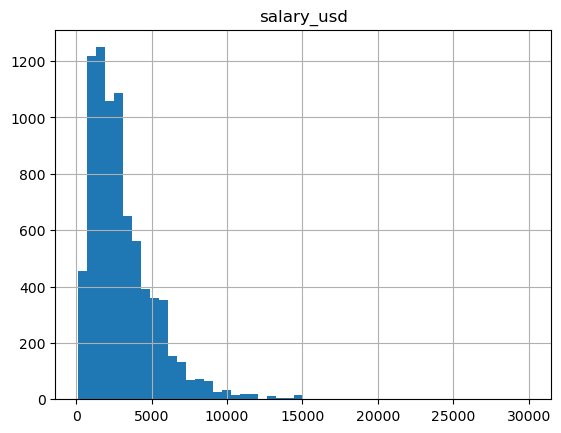

In [68]:
balanced_df.hist('salary_usd', bins=50)
plt.show()


In [71]:
# Словник для уніфікації категорій
category_mapping = {
    # Customer Support дублікати
    'Customer Support': 'Customer Support',
    'customer support': 'Customer Support',  # з маленької літери
    'Technical Support': 'Customer Support',

    # Management категорії
    'Project Management': 'Management',
    'Product Management': 'Management',
    'Other Management': 'Management',
    'Other mgmt': 'Management',
    'General Leadership': 'Management',
    'Tech Leadership': 'Management',
    'Agile Mgmt': 'Management',
    'Office manager / Admin / Assistant': 'Management',

    # Design категорії
    'UI/UX, Product Design': 'Design',
    'Design': 'Design',
    'Artist/Animator': 'Design',
    'Game design': 'Design',

    # Support категорії
    'Support': 'Customer Support',

    # Tech Writing
    'Tech Wr./Lclz': 'Technical Writing',

    # Дуже малі категорії об'єднуємо в Other
    'Rcrt': 'Other',  # 210 -> можна залишити окремо якщо потрібно
    'Brand': 'Marketing',  # логічно до Marketing
    'LD': 'Other',  # незрозуміло що це
    'DBA': 'DevOps',  # Database Admin -> DevOps
    'Hardware': 'Other',
    'Legal': 'Other',
    'Finance': 'Other',
    'Consultant': 'Other',
    'Customer Success': 'Customer Support',

    # Залишаємо як є (великі категорії)
    'Quality Assurance': 'Quality Assurance',
    'Software Engineer': 'Software Engineer',
    'Analyst': 'Analyst',
    'DevOps': 'DevOps',
    'Data Scientist': 'Data Scientist',
    'HR': 'HR',
    'Marketing': 'Marketing',
    'Sales': 'Sales',
    'SysAdmin': 'SysAdmin',
    'Security': 'Security'
}

# Застосування маппінгу
balanced_df['category_unified'] = balanced_df['category'].map(category_mapping).fillna('Other')

# Подивитися результат
print("Після уніфікації:")
print(balanced_df['category_unified'].value_counts())

# Замінити оригінальну колонку
balanced_df['category'] = balanced_df['category_unified']
balanced_df.drop('category_unified', axis=1, inplace=True)


Після уніфікації:
category_unified
Quality Assurance    1973
Software Engineer    1463
Management           1095
Analyst               551
Design                530
DevOps                514
Marketing             398
Other                 362
Data Scientist        330
HR                    281
Customer Support      188
Sales                 133
SysAdmin              130
Security               57
Technical Writing      24
Name: count, dtype: int64


In [72]:
balanced_df


,salary_usd,title,category,english_level,it_experience_years
0,2000.0,Middle,Analyst,Pre-Intermediate,2.0
1,4000.0,Senior,Quality Assurance,Intermediate,5.0
2,10000.0,Lead / Team Lead,DevOps,Upper-Intermediate,9.0
3,3500.0,Senior,Management,Advanced,5.0
4,3000.0,Lead / Team Lead,Management,Pre-Intermediate,18.0
...,...,...,...,...,...
8024,3227.0,Lead / Team Lead,HR,Advanced,7.0
8025,7500.0,Senior,Data Scientist,Upper-Intermediate,4.0
8026,1450.0,Lead / Team Lead,Customer Support,Pre-Intermediate,1.5
8027,9000.0,Senior,Software Engineer,Intermediate,20.0


In [ ]:
balanced_df.to_csv(DATA_DIR / "prep_data_v2.csv", index = False)
